In [96]:
!pip install graphviz numpy matplotlib


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

%matplotlib inline


In [6]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5


In [7]:
f(3.0)


20.0

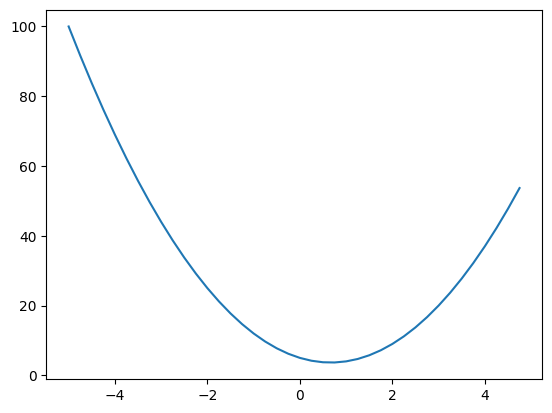

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [9]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x)) / h


0.0

In [101]:
class Value:
    def __init__(self, data: float, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)
                          ), "only supporting int/floats for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L


Value(data=-8.0)

In [18]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" %
                 (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


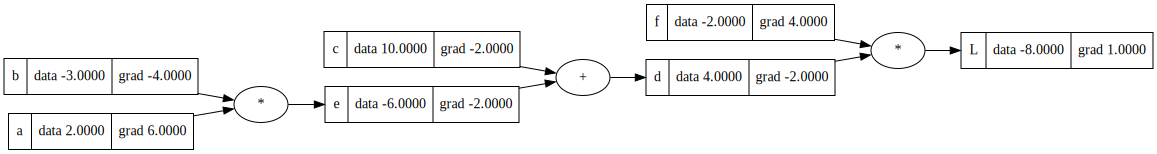

In [22]:
draw_dot(L)


In [21]:
L.grad = 1.0  # derivate of itself
f.grad = 4.0  # value of d, b.c. d(d * f)/df
d.grad = -2.0  # value of f, b.c. d(d * f)/dd
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0


In [98]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137335870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()


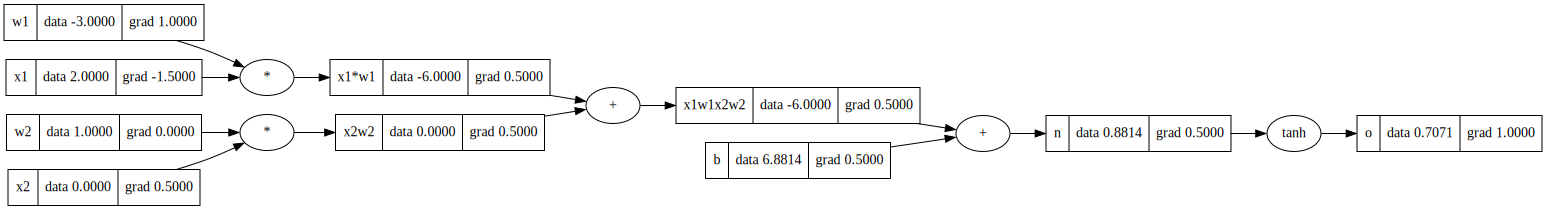

In [99]:
draw_dot(o)

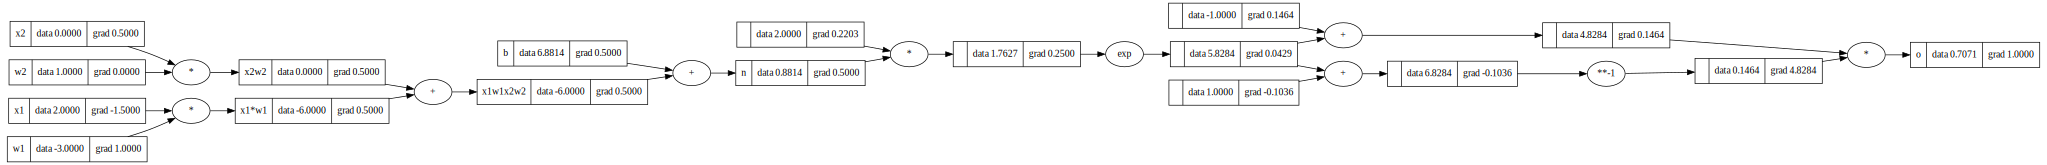

In [102]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137335870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)


In [104]:
!pip install torch

  Using cached torch-2.0.0-cp310-none-macosx_10_9_x86_64.whl (139.8 MB)
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached filelock-3.10.7-py3-none-any.whl (10 kB)
  Using cached MarkupSafe-2.1.2-cp310-cp310-macosx_10_9_x86_64.whl (13 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [105]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88113735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7069886534797297
---
x2 0.5001670438509187
w2 0.0
x1 -1.500501131552756
w1 1.0003340877018374
